In [24]:

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, classification_report
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
# import warnings
# warnings.filterwarnings("ignore", message=".*Found unknown categories.*")

In [25]:
df = pd.read_csv(r"C:\Python 2k25\test_datasets\archive\crx.csv", header=None).dropna()
df.columns = ['Gender','Age','Debt_(millions)','Status','Property','Designation','Area','Credit_Amount_(millions)','Senior_citizen','1-Link',
              'Number_of_accounts','Government_Employee','International_Banking','Frozen_Amount','Savings','Credit_card_approval']
print('Dataset has been loaded! \n', df)


Dataset has been loaded! 
     Gender    Age  Debt_(millions) Status Property Designation Area  \
0        b  30.83            0.000      u        g           w    v   
1        a  58.67            4.460      u        g           q    h   
2        a   24.5            0.500      u        g           q    h   
3        b  27.83            1.540      u        g           w    v   
4        b  20.17            5.625      u        g           w    v   
..     ...    ...              ...    ...      ...         ...  ...   
685      b  21.08           10.085      y        p           e    h   
686      a  22.67            0.750      u        g           c    v   
687      a  25.25           13.500      y        p          ff   ff   
688      b  17.92            0.205      u        g          aa    v   
689      b     35            3.375      u        g           c    h   

     Credit_Amount_(millions) Senior_citizen 1-Link  Number_of_accounts  \
0                        1.25              t 

In [26]:
df['Age'] = df['Age'].astype(str)
df['Age'] = df['Age'].str.strip()
missing_tokens = {'?', 'NA', 'NaN', 'nan', 'NULL', 'null', '', ' '}
df['Age'] = df['Age'].where(~df['Age'].isin(missing_tokens), other=None)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Age'].dtype  # should be float64
df['Age'].isna().sum()  # count of missing after coercion


X = df.drop('Credit_card_approval', axis=1)
# X = df[['Senior_citizen', 'Frozen_Amount', 'Savings', 'Number_of_accounts', 'Credit_Amount_(millions)', 'Property', 'Status']]

df['Credit_card_approval'] = df['Credit_card_approval'].replace({'+':'Approved', '-':'Rejected'})   #replacing signs with descriptive data
df['Age'] = df['Age'].replace({'?' : np.nan, 'NA': np.nan, 'Nan': np.nan, 'nan': np.nan})
# Fill missing Age values with the median
X['Age'] = X['Age'].fillna(X['Age'].median())
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
y = df['Credit_card_approval']

X.isnull().sum()
# print(X)
# print(y)
# print(X['Age'].dtype)

Gender                      0
Age                         0
Debt_(millions)             0
Status                      0
Property                    0
Designation                 0
Area                        0
Credit_Amount_(millions)    0
Senior_citizen              0
1-Link                      0
Number_of_accounts          0
Government_Employee         0
International_Banking       0
Frozen_Amount               0
Savings                     0
dtype: int64

In [27]:


num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print('Numeric features:', num_features)
print('categorical features:', cat_features)

# y_xgb = y.map({'Rejected': 0, 'Approved': 1})   # or reverse if you prefer

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
])

pipe = Pipeline(steps=[
    ('preprocessor' , preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        # n_jobs=-1,
        # eval_metric='logloss',      # Good default for classification
        # use_label_encoder=False     # Avoids warnings
        # probability=True
    ))
])
validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

parameters = [
    {
   
        'model' : [RandomForestClassifier()],
        'model__n_estimators': [1000],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt'],
        'model__random_state' : [42],
        'model__class_weight' : ['balanced']

    },
    # {
    #     'model' : [LogisticRegression()],
    #     'model__C': [0.01, 0.1, 1, 10, 100],
    #     'model__penalty': ['l1', 'l2'],
    #     'model__solver': ['liblinear', 'saga'],          # both support l1 and l2
    #     'model__class_weight': [None, 'balanced']

    # }
    # { 
    #     'model' : [SVC()],
    #     'model__C': [0.1, 1, 10, 100],
    #     'model__kernel': ['rbf', 'linear'],
    #     'model__gamma': ['scale', 'auto', 0.01, 0.1],
    #     'model__class_weight': [None, 'balanced'],

    # },
    # {
    #     'model__n_estimators': [300, 500, 800],
    #     'model__max_depth': [3, 6, 10],
    #     'model__learning_rate': [0.01, 0.1, 0.3],
    #     'model__subsample': [0.8, 1.0],
    #     'model__colsample_bytree': [0.8, 1.0],
    #     'model__scale_pos_weight': [1]   # Or calculate for imbalance if needed
    # }
]
grid = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring='f1_weighted',
    cv = validation,
)

grid.fit(X, y)
print('Model has been trained !')
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)



Numeric features: ['Age', 'Debt_(millions)', 'Credit_Amount_(millions)', 'Number_of_accounts', 'Savings']
categorical features: ['Gender', 'Status', 'Property', 'Designation', 'Area', 'Senior_citizen', '1-Link', 'Government_Employee', 'International_Banking', 'Frozen_Amount']


c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warning

Model has been trained !
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Debt_(millions)',
                                                   'Credit_Amount_(millions)',
                                                   'Number_of_accounts',
                                                   'Savings']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Status',
                                                   'Property', 'Designation',
                                                   'Area', 'Senior_citizen',
                                                   '1-Link',
                                                   'Government

c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2, 9] during transform. These unknown categories will be encoded as all zeros
  w

[[253  54]
 [ 57 326]]


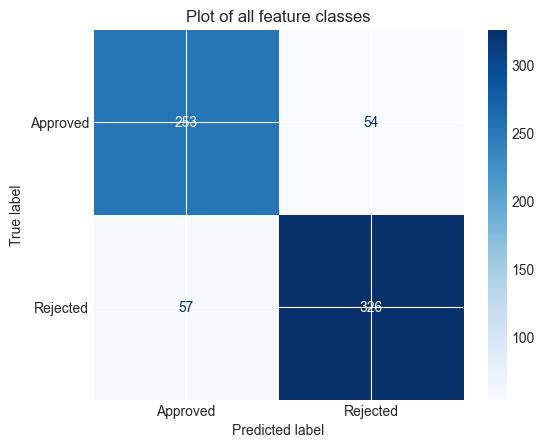

              precision    recall  f1-score   support

    Approved       0.82      0.82      0.82       307
    Rejected       0.86      0.85      0.85       383

    accuracy                           0.84       690
   macro avg       0.84      0.84      0.84       690
weighted avg       0.84      0.84      0.84       690



In [28]:
pred = cross_val_predict(pipe, X, y, method='predict', cv=5)
cm = confusion_matrix(y, pred)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=grid.classes_).plot(cmap='Blues')
plt.title("Plot of all feature classes")
plt.show()
print(classification_report(y, pred))

In [29]:
print(y.value_counts())

print(y.value_counts(normalize=True))

Credit_card_approval
Rejected    383
Approved    307
Name: count, dtype: int64
Credit_card_approval
Rejected    0.555072
Approved    0.444928
Name: proportion, dtype: float64


In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    grid.best_estimator_, X, y,
    n_repeats=10, random_state=42, n_jobs=-1
)

pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)


Senior_citizen              0.141014
Designation                 0.015652
Savings                     0.012319
Debt_(millions)             0.012029
1-Link                      0.010435
Number_of_accounts          0.010000
Credit_Amount_(millions)    0.008261
Age                         0.007681
Area                        0.006812
Frozen_Amount               0.006232
International_Banking       0.005652
Government_Employee         0.004783
Gender                      0.004783
Property                    0.004783
Status                      0.002609
dtype: float64

c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\pr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2, 9] during transform. These unknown categories will be encoded as all zeros
  w

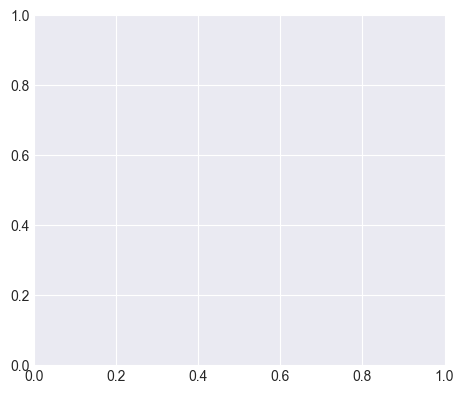

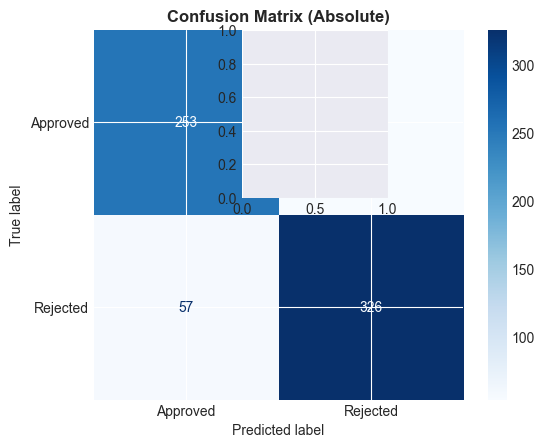

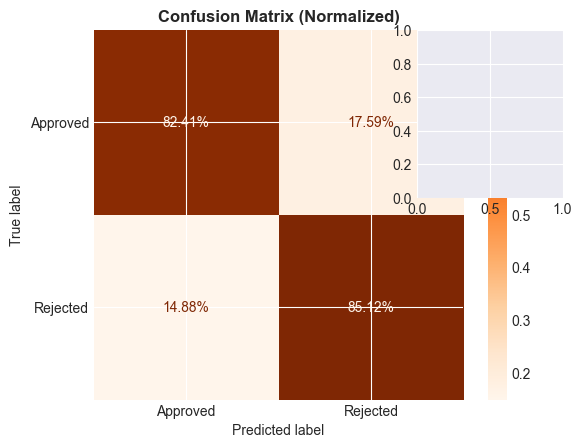

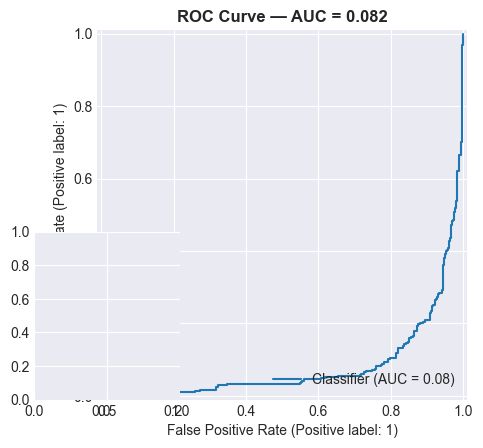

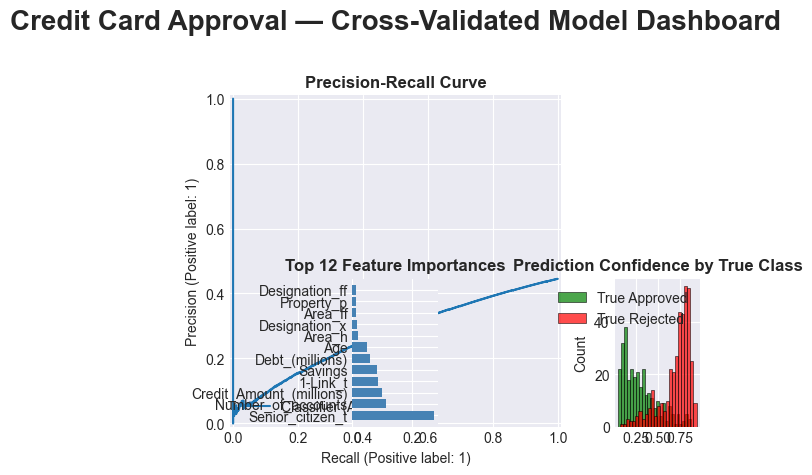

In [31]:

from sklearn.metrics import (
    RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score)
y_proba = cross_val_predict(grid.best_estimator_, X, y, cv=5, method='predict_proba')[:, 1]

# 7. Visualizations (6-panel dashboard)
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 10))

# Confusion Matrix (absolute)
plt.subplot(2, 3, 1)
ConfusionMatrixDisplay.from_predictions(y, pred, cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Absolute)', fontweight='bold')

# Normalized Confusion Matrix
plt.subplot(2, 3, 2)
ConfusionMatrixDisplay.from_predictions(y, pred, cmap='Oranges', normalize='true', values_format='.2%')
plt.title('Confusion Matrix (Normalized)', fontweight='bold')


y_binary = y.map({'Approved': 1, 'Rejected': 0})   # Convert to 1 and 0 for ROC/PR curves
# ROC Curve
plt.subplot(2, 3, 3)
RocCurveDisplay.from_predictions(y_binary, y_proba)
plt.title(f'ROC Curve — AUC = {roc_auc_score(y_binary, y_proba):.3f}', fontweight='bold')

# Precision-Recall Curve
plt.subplot(2, 3, 4)
PrecisionRecallDisplay.from_predictions(y_binary, y_proba)
plt.title('Precision-Recall Curve', fontweight='bold')

# Feature Importance (top 12)
plt.subplot(2, 3, 5)
importances = grid.best_estimator_.named_steps['model'].feature_importances_
feat_names = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[-12:]
plt.barh(range(12), importances[indices], color='steelblue')
plt.yticks(range(12), [n.split('__')[-1] for n in np.array(feat_names)[indices]])
plt.title('Top 12 Feature Importances', fontweight='bold')
plt.gca().invert_yaxis()

# Prediction Confidence Distribution
plt.subplot(2, 3, 6)
sns.histplot(y_proba[y=='Approved'], bins=25, alpha=0.7, label='True Approved', color='green')
sns.histplot(y_proba[y=='Rejected'], bins=25, alpha=0.7, label='True Rejected', color='red')
plt.title('Prediction Confidence by True Class', fontweight='bold')
plt.legend()

plt.suptitle('Credit Card Approval — Cross-Validated Model Dashboard', 
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()